In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
# from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [2]:
#load pre-trained embedding:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/crawl-300d-2M.vec.zip", 'r')
zip_ref.extractall()
zip_ref.close()
embeddings_index = {}
f = open('/content/crawl-300d-2M.vec', encoding="utf8")
for line in f:
    values = line.split()#This splits each values in a  line with spaces
    word = values[0] # This store the first values which is the word in english
    coefs = np.asarray(values[1:], dtype='float32') # This converts all splitted values from 1 to last(expect first word) into an array
    embeddings_index[word] = coefs # english word = array of numerical values
f.close()
print('Total %s word vectors in crawl-300-2M.' % len(embeddings_index))

Total 1999996 word vectors in crawl-300-2M.


In [0]:
def load_csv(path):
  df=pd.read_csv(path).drop(['Sub-task B','ID'],axis=1)
  df=df[(df['Sub-task A']=="NAG")|(df['Sub-task A']=='CAG')|(df['Sub-task A']=='OAG')].dropna()
  df['Sub-task A'] = df['Sub-task A'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
  return df

In [138]:
train_df=load_csv("/content/drive/My Drive/eng_train.csv")
dev_df=load_csv('/content/drive/My Drive/eng_dev.csv')
print(train_df.head())
print(dev_df.head())

                                                Text  Sub-task A
0                                          Next part           0
1                 Iii8mllllllm\nMdxfvb8o90lplppi0005           0
2  🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...           0
3  What the fuck was this? I respect shwetabh and...           0
4  Concerned authorities should bring arundathi R...           0
                                                Text  Sub-task A
0        U deserve more subscribers. U really great.           0
1                                     Nice video....           0
2  sorry if i bother somebody.. iam a defence asp...           0
3  Joker was amazing....it was not glamorised !.....           0
4                                          Nice baro           0


In [139]:
train_df.shape,dev_df.shape

((4263, 2), (1066, 2))

In [140]:
print(train_df['Sub-task A'].value_counts())
print(dev_df['Sub-task A'].value_counts())

0    3375
1     453
2     435
Name: Sub-task A, dtype: int64
0    836
1    117
2    113
Name: Sub-task A, dtype: int64


In [141]:
train_line=train_df['Text'].apply(lambda x: nltk.word_tokenize(x))
dev_line=dev_df['Text'].apply(lambda x: nltk.word_tokenize(x))
dev_line,train_line

(0       [U, deserve, more, subscribers, ., U, really, ...
 1                                   [Nice, video, ..., .]
 2       [sorry, if, i, bother, somebody.., iam, a, def...
 3       [Joker, was, amazing, ..., .it, was, not, glam...
 4                                            [Nice, baro]
                               ...                        
 1061    [Ranu, Mandal, is, third, class, [, woman.No, ...
 1062    [[, 15:23, ], (, https, :, //www.youtube.com/w...
 1063                         [Love, u, bro, keep, it, up]
 1064                               [May, I, help, you, ?]
 1065    [You, are, great, sir, !, !, !, When, a, i, sa...
 Name: Text, Length: 1066, dtype: object,
 0                                            [Next, part]
 1                    [Iii8mllllllm, Mdxfvb8o90lplppi0005]
 2       [🤣🤣😂😂🤣🤣🤣😂osm, vedio, ..., .keep, it, up, ..., ...
 3       [What, the, fuck, was, this, ?, I, respect, sh...
 4       [Concerned, authorities, should, bring, arunda...
              

In [142]:
# tk=Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ")
tk=Tokenizer(lower=True,split=" ")
tk.fit_on_texts(train_line)
word_index=tk.word_index
word_index

{'.': 1,
 'the': 2,
 'is': 3,
 'and': 4,
 ',': 5,
 'to': 6,
 'i': 7,
 'a': 8,
 'of': 9,
 '...': 10,
 'you': 11,
 'in': 12,
 'this': 13,
 'it': 14,
 'are': 15,
 '?': 16,
 'that': 17,
 '!': 18,
 'not': 19,
 'for': 20,
 'movie': 21,
 'like': 22,
 'but': 23,
 'on': 24,
 'be': 25,
 "n't": 26,
 "'s": 27,
 'with': 28,
 'do': 29,
 'so': 30,
 'have': 31,
 'u': 32,
 'kabir': 33,
 'your': 34,
 'was': 35,
 'they': 36,
 'he': 37,
 'she': 38,
 'people': 39,
 'singh': 40,
 'about': 41,
 'who': 42,
 'we': 43,
 'all': 44,
 'as': 45,
 'what': 46,
 ')': 47,
 'from': 48,
 'love': 49,
 'her': 50,
 'review': 51,
 ':': 52,
 'his': 53,
 'if': 54,
 'will': 55,
 '(': 56,
 'video': 57,
 'should': 58,
 'good': 59,
 'can': 60,
 'very': 61,
 '@': 62,
 'or': 63,
 'right': 64,
 'my': 65,
 'by': 66,
 'one': 67,
 'just': 68,
 'no': 69,
 '&': 70,
 'me': 71,
 'india': 72,
 'has': 73,
 'these': 74,
 'bro': 75,
 'nice': 76,
 'movies': 77,
 'watch': 78,
 'why': 79,
 'their': 80,
 'man': 81,
 'sir': 82,
 'only': 83,
 'also':

In [143]:
import math
length=math.ceil(np.average(train_line.apply(lambda x:len(x))))
length

20

In [0]:
def encode_text(tokenizer, lines, length):
  encoded = tokenizer.texts_to_sequences(lines)
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

In [145]:
train_x=encode_text(tk,train_line,length)
print(train_x)
dev_x=encode_text(tk,dev_line,length)
print(dev_x)

[[  509   325     0 ...     0     0     0]
 [ 3983  3984     0 ...     0     0     0]
 [ 3985  1002    10 ...     0     0     0]
 ...
 [    6  1196   503 ... 10368   470    18]
 [   62 10369 10370 ...     0     0     0]
 [   43   101     6 ...     0     0     0]]
[[ 32 594  85 ...   0   0   0]
 [ 76  57  10 ...   0   0   0]
 [ 56 112   3 ... 672  92  10]
 ...
 [ 49  32  75 ...   0   0   0]
 [301   7 522 ...   0   0   0]
 [ 82  18  18 ...  95   2  21]]


In [146]:
vocab_size = len(tk.word_index)
print(vocab_size)

10370


In [147]:
embeddings_index['🤣'].shape

(300,)

In [0]:
# Initialize the weight for each word for the embedding layer. Words not present
# in the dictionary initialized by random value 
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#embedding_matrix = (10370, 300) NOTE: It is from uniques words in our tweets
for word, i in word_index.items(): # Selecting word from our tweet unique words list for changing with the values from glove
    embedding_vector = embeddings_index.get(word) # Finding our tweet words in glove and taking its array of 100 values
    if embedding_vector is not None: 
#words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [149]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(train_df['Sub-task A']))
y_test = to_categorical(np.asarray(dev_df['Sub-task A']))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(4263, 3) (1066, 3)


In [150]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 300, weights=[embedding_matrix], input_length=length,trainable=False))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 300)           3111300   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 18, 128)           115328    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 3, 128)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 3, 128)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               98560     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)             

In [151]:
history=model.fit(train_x, y_train, validation_data = (dev_x, y_test),epochs=100,batch_size=100, verbose=2)

Train on 4263 samples, validate on 1066 samples
Epoch 1/100
 - 1s - loss: 0.7310 - acc: 0.7640 - val_loss: 0.6113 - val_acc: 0.7842
Epoch 2/100
 - 0s - loss: 0.6273 - acc: 0.7912 - val_loss: 0.6144 - val_acc: 0.7842
Epoch 3/100
 - 0s - loss: 0.5747 - acc: 0.7938 - val_loss: 0.5772 - val_acc: 0.7842
Epoch 4/100
 - 0s - loss: 0.5477 - acc: 0.7980 - val_loss: 0.5576 - val_acc: 0.7814
Epoch 5/100
 - 0s - loss: 0.5003 - acc: 0.8079 - val_loss: 0.5462 - val_acc: 0.7908
Epoch 6/100
 - 0s - loss: 0.4510 - acc: 0.8285 - val_loss: 0.5524 - val_acc: 0.7871
Epoch 7/100
 - 0s - loss: 0.4044 - acc: 0.8438 - val_loss: 0.5668 - val_acc: 0.7964
Epoch 8/100
 - 0s - loss: 0.3518 - acc: 0.8740 - val_loss: 0.5716 - val_acc: 0.7917
Epoch 9/100
 - 0s - loss: 0.3061 - acc: 0.8874 - val_loss: 0.6147 - val_acc: 0.7608
Epoch 10/100
 - 0s - loss: 0.2725 - acc: 0.9031 - val_loss: 0.6429 - val_acc: 0.7795
Epoch 11/100
 - 0s - loss: 0.2226 - acc: 0.9233 - val_loss: 0.6812 - val_acc: 0.7880
Epoch 12/100
 - 0s - loss:

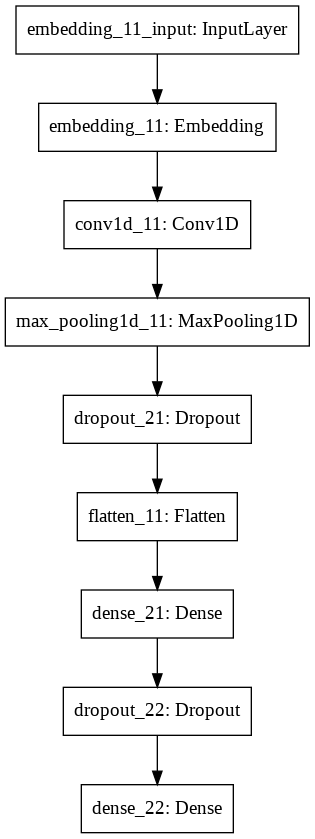

In [152]:
plot_model(model)

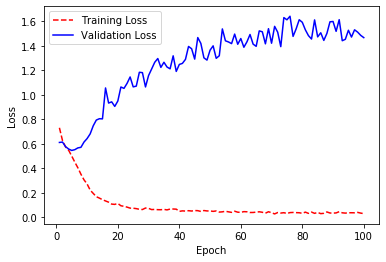

In [153]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [154]:
scores = model.evaluate(dev_x, y_test, verbose=0)
print(scores)

[1.4669884047409831, 0.7776735458544003]


In [155]:
predictions_test = model.predict(dev_x)
print(predictions_test)

[[9.99942422e-01 3.14567515e-05 2.60930628e-05]
 [1.00000000e+00 6.16561602e-09 6.64065469e-09]
 [9.98813033e-01 1.18685677e-03 1.07128415e-07]
 ...
 [9.99999881e-01 4.89837255e-08 6.15898870e-08]
 [9.99999523e-01 1.09186423e-07 3.27739741e-07]
 [9.99089718e-01 9.02110361e-04 8.22771653e-06]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [157]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       836
           1       0.30      0.15      0.20       117
           2       0.43      0.35      0.38       113

   micro avg       0.78      0.78      0.78      1066
   macro avg       0.53      0.47      0.49      1066
weighted avg       0.74      0.78      0.75      1066
 samples avg       0.78      0.78      0.78      1066



In [0]:
model.save('EngTaskAmodel.h5')